In [27]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from analysis_tools import getobjdata

from tools.cbook import pickle2Obj, interp_z, compute_thetae
from tools.FV3_tools import read_solo_fields, read_solo_w, read_solo_w2
from tools.CM1_tools import read_cm1_fields

import scipy.ndimage as ndimage
import matplotlib.colors as mcolors

from colormaps import radar_colormap

from timeit import default_timer as timer

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

from tools.cbook import pickle2Obj

_nthreads = 10

zlevels = 10.0 + 250.*np.arange(61)

velocity_unicode = "m s\u207B\u00B9"
massflux_unicode = "kg s\u207B\u00B9"

# draw filled contours.
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]

cmap_data = [(1.0, 1.0, 1.0),
         (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
         (0.0, 1.0, 1.0),
         (0.0, 0.8784313797950745, 0.501960813999176),
         (0.0, 0.7529411911964417, 0.0),
         (0.501960813999176, 0.8784313797950745, 0.0),
         (1.0, 1.0, 0.0),
         (1.0, 0.6274510025978088, 0.0),
         (1.0, 0.0, 0.0),
         (1.0, 0.125490203499794, 0.501960813999176),
         (0.9411764740943909, 0.250980406999588, 1.0),
         (0.501960813999176, 0.125490203499794, 1.0),
         (0.250980406999588, 0.250980406999588, 1.0),
         (0.125490203499794, 0.125490203499794, 0.501960813999176),
         (0.125490203499794, 0.125490203499794, 0.125490203499794),
         (0.501960813999176, 0.501960813999176, 0.501960813999176),
         (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
         (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
         (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
         (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
         (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)


savePlots = False

models = {}
# start = timer()
# cm1  = read_cm1_fields('/work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S12', vars = ['w'], zinterp=zlevels, ret_ds=False)
# solo = read_solo_fields('/work/wicker/climate_runs/FV3_Solo/squall/euler/3km/QV16/S18', vars = ['w'], zinterp=zlevels, ret_ds=False)

# end = timer()

# print(f"Time to read file: {end - start:.2f} sec")

# plt.contourf(cm1['w'][15,:,128,:]);
# plt.plot()
# # plt.contourf(solo['w'][15,:,128,:]);
# print(cm1['w'].shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Just read stuff back in...
from matplotlib.colors import LinearSegmentedColormap         

def make_plot(data, label, time = 1, klevel = 18, ax_in = None, xlim=None, ylim=None, fig=None):

    if ax_in == None:
        fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(7,7))
    else:
        ax = ax_in

    # DBZ  = data[label]['dbz'][time]
    W    = data[label]['w'][time]
    # PRES = data[label]['pres'][time]
    THpert  = data[label]['pert_th'][time]
        
    # mask_cref   = np.where(DBZ.max(axis=0) > cref_thresh, True, False)
    # mask_w_3d   = np.where(PRES < 70000.0, W, np.nan)

    # mask_w_2d   = np.nanmax(mask_w_3d, axis=0)
    # mask_w_cref = (mask_w_2d > w_thresh) & mask_cref
    # f_mask      = mask_w_cref.astype(np.int8)

    precip  = data[label]['accum_prec'][time-4:time].sum(axis=0)
        
    # ctable = radar_colormap()
    # levels = [5 + 5*n for n in range(15)]

    # colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
    colors = [(1, 1, 1) ]
    cmap_name = 'my_list'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=2)
    
    x = 3.0*np.arange(W.shape[1])
    y = 3.0*np.arange(W.shape[2])
    xx, yy = np.meshgrid(x,y)

    TH_cp = np.where(THpert[0] <= -1.0, -1.0, np.nan)
    ax.pcolor(xx, yy, TH_cp, cmap=plt.get_cmap('bone'), alpha=0.05, edgecolors="face")

    p_mask = np.where(precip > 1.0, precip, np.nan)
    pmax   = precip.max()
    ptotal = precip.sum()
    
    precip_plot = ax.contourf(xx, yy, p_mask, clevs, cmap=plt.cm.get_cmap('BrBG'), norm=mlab.colors.PowerNorm(gamma=0.2))

    if fig != None:
        cbar = fig.colorbar(precip_plot, ax=ax, shrink=0.9, location='right')
        cbar.set_label('(mm)', fontsize=12)

    Wmax =  np.where( W.max(axis=0) >= 3.0, 3.0, np.nan)

    ax.contourf(xx, yy, Wmax, levels = [3.0,3.1], colors= 'k', alpha=0.7)

    if xlim != None:
        ax.set_xlim(xlim[0:2])
        ax.set_xlabel(xlim[2], fontsize=14)
    if ylim != None:
        ax.set_ylim(ylim[0:2])
        ax.set_ylabel(ylim[2], fontsize=14)

    if ax_in == None:
        return W, ax
    else:
        return W, precip_plot
        

In [22]:
#----------------------------- READ DATA IN ---------------

paths = {}
paths['cm1_QV16_S18']  = '/work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S18'
paths['solo_QV16_S18'] = '/work/wicker/climate_runs/FV3_Solo/squall/euler/3km/QV16/S18'
paths['cm1_QV13_S18']  = '/work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV13/S18'
paths['solo_QV13_S18'] = '/work/wicker/climate_runs/FV3_Solo/squall/euler/3km/QV13/S18'

paths = {}
paths['cm1']  = '/work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S18'
paths['solo'] = '/work/wicker/climate_runs/FV3_Solo/squall/euler/3km/QV16/S18'

models = {}

for key in paths:
    print("\n Reading: ",key)
    if key[0:3] == 'cm1':
        models[key] = ( read_cm1_fields(paths[key], vars = ['w', 'pert_th', 'accum_prec','rwqv', 'rw'], zinterp=zlevels, ret_ds=False) )
    if key[0:4] == 'solo':
        models[key] = ( read_solo_fields(paths[key], vars = ['w', 'pert_th', 'accum_prec','rwqv', 'rw'], zinterp=zlevels, ret_ds=False) )


 Reading:  cm1
------------------------------------------------------------------------------------------------------------------------

 Now reading... /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S18/cm1out.nc

 Time for xarray to load:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S18/cm1out.nc: 12.79 sec 

 Completed setup for:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S18/cm1out.nc --> time to initialize variables: 1.17 sec 

 Completed reading in:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S18/cm1out.nc --> time to read file: 0.28 sec 
------------------------------------------------------------------------------------------------------------------------

 Interpolating fields to single column z-grid: /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S18/cm1out.nc 

 Finished interp fields to single column z-grid:  /work/wicker/climate_runs/cm1r20.3/run/squall/3km/QV16/S18: 33.52 sec 


 Reading:  solo
-------------------------

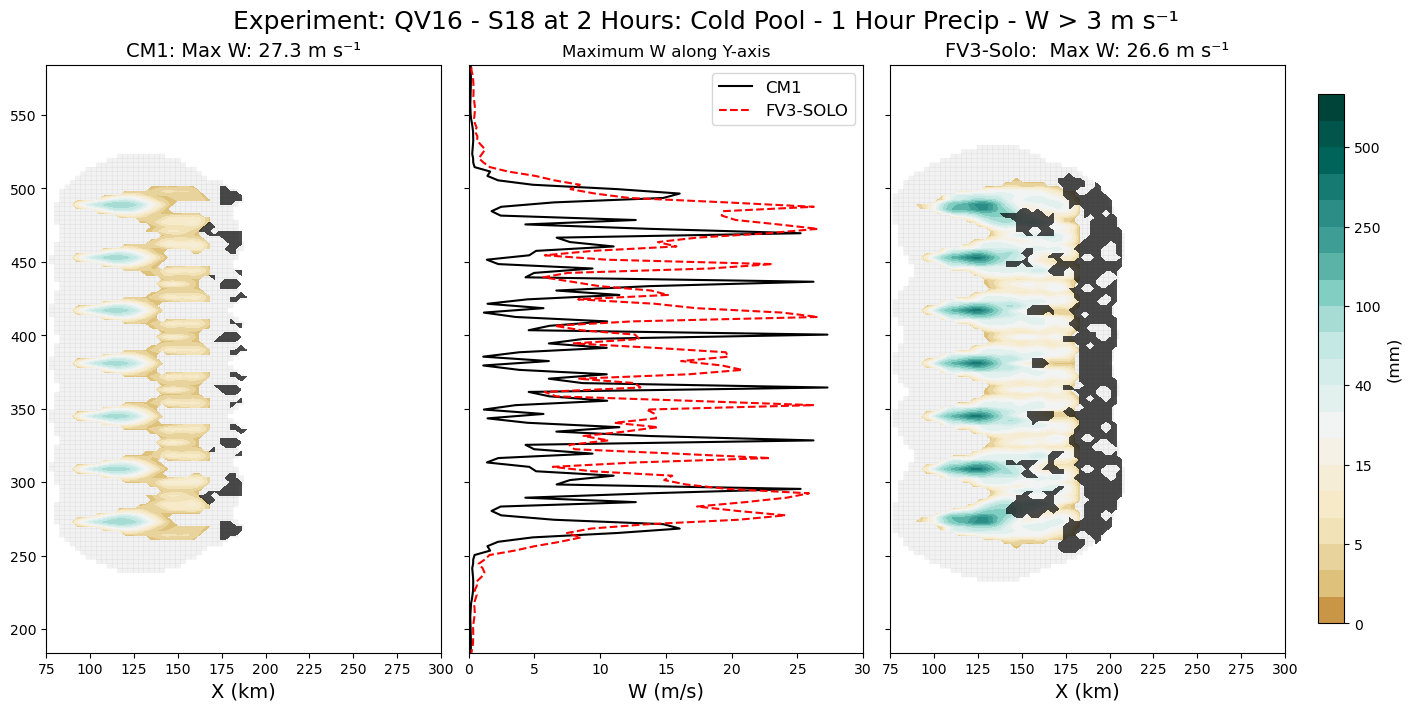

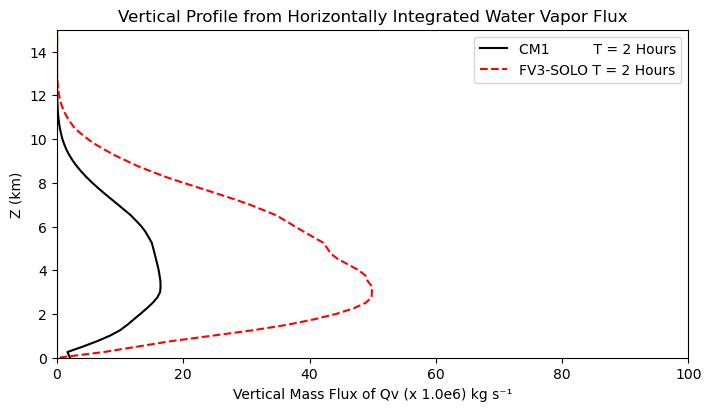

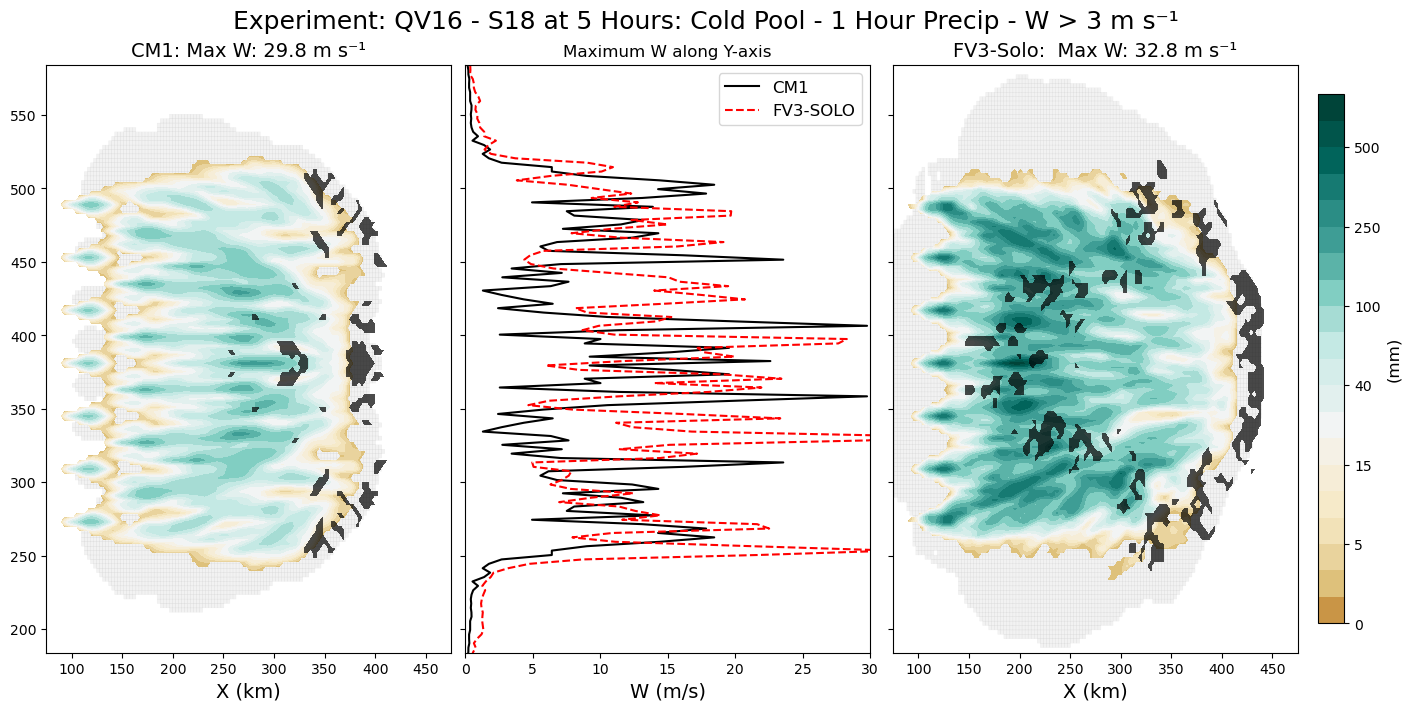

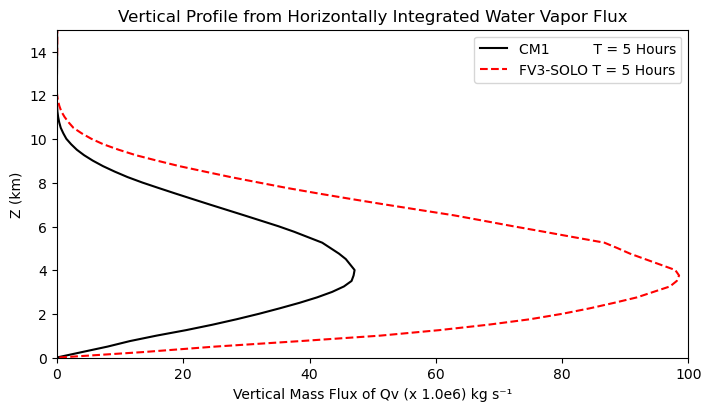

In [23]:
#----------------------------- READ DATA IN ---------------

nmodels = len(models.keys())

label = "QV16 - S18"
yc    = models['cm1']['yc'] / 1000.

qvscale = 3000.*3000. / 1.0e6

for n in [7, 19,]:

    match n:

        case 7: 
            width = 400
            ycntr = 384.
            xs    = 75.
            xe    = 300.
            xlim = [xs, xe, 'X (km)']
            ylim = [ycntr-width/2, ycntr+width/2, None]

        case _: 
            width = 400
            ycntr = 384.
            xs    = 75.
            xlim = [xs, xs+width, 'X (km)']
            ylim = [ycntr-width/2, ycntr+width/2, None]

    fig, ax = plt.subplots(1, 3, sharey=True, constrained_layout=True, figsize=(7*nmodels,7))

    w_cm1, _ = make_plot(models, 'cm1', ax_in = ax[0], time=n, xlim=xlim, ylim=ylim)
    ax[0].set_title(f"CM1: Max W: {w_cm1.max():.1f} {velocity_unicode}", fontsize=14)
    
    w_solo, cptr = make_plot(models, 'solo', ax_in = ax[2], time=n, xlim=xlim, ylim=ylim, fig=fig)
    ax[2].set_title(f"FV3-Solo:  Max W: {w_solo.max():.1f} {velocity_unicode}", fontsize=14)
    
    # cbar = fig.colorbar(cptr, ax=ax[2], shrink=0.9, location='right')
    # cbar.set_label('(mm)', fontsize=12)

    ax[1].plot(w_cm1.max(axis=(0,2)), yc, color='k', linestyle='-' ,  label=f'CM1')
    ax[1].plot(w_solo.max(axis=(0,2)), yc, color='r', linestyle='--', label=f'FV3-SOLO')

    ax[1].set_ylim(ylim[0:2])
    ax[1].set_xlim(0.0, 30.)
    ax[1].set_title("Maximum W along Y-axis", fontsize=12)
    ax[1].set_xlabel('W (m/s)', fontsize=14)
    ax[1].legend(fontsize=12)
    ax[0].set_ylabel(ylim[2], fontsize=14)

    plt.suptitle(f"Experiment: {label} at {(n+1)//4} Hours: Cold Pool - 1 Hour Precip - W > 3 {velocity_unicode}", fontsize=18)
    
    plt.savefig(f"./Figures/SquallPlots_{label}_Hour{(n+1)//4:2d}.pdf")

    plt.show()

# Water vapor flux

    fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(7,4))

    ax.plot(qvscale*models['cm1']['rwqv'][n].sum(axis=(1,2)), zlevels/1000., color='k', 
            linestyle='-', label=f'CM1          T = {(n+1)//4} Hours')
    ax.plot(qvscale*models['solo']['rwqv'][n].sum(axis=(1,2)), zlevels/1000., color='r', 
            linestyle='--',  label=f'FV3-SOLO T = {(n+1)//4} Hours')

    ax.set_ylim(0.0,15.)
    ax.set_xlim(0.0, 100.)
    ax.set_xlabel(f'Vertical Mass Flux of Qv (x 1.0e6) {massflux_unicode}');
    ax.set_ylabel('Z (km)');
    ax.legend();
    ax.set_title('Vertical Profile from Horizontally Integrated Water Vapor Flux');

    plt.savefig(f"./Figures/Squall_MFLUX_{label}_Hour{(n+1)//4:2d}.pdf")